In [54]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (3, 3)

from matscipy.dislocation import get_elastic_constants, plot_vitek

from ase.optimize.precon import PreconLBFGS

from ovito.io.ase import ase_to_ovito
from ovito.modifiers import CommonNeighborAnalysisModifier, IdentifyDiamondModifier
from ovito.pipeline import StaticSource, Pipeline

# Get the results of Ovito Common Neighbor Analysis 
# https://www.ovito.org/docs/current/reference/pipelines/modifiers/common_neighbor_analysis.html
# and Identify Diamond modifier
# https://www.ovito.org/docs/current/reference/pipelines/modifiers/identify_diamond.html
# for better visualisation of the dislocation core
# it will be identified as "other" structure type
def get_structure_types(structure, diamond_structure=False):
    """Get the results of Common Neighbor Analysis and 
        Identify Diamond modifiers from Ovito
    Args:
        structure (ase.atoms): input structure
    Returns:
        atom_labels (array of ints): per atom labels of the structure types
        structure_names (list of strings): names of the structure types
        colors (list of strings): colors of the structure types in hex format
    """
    ovito_structure = structure.copy()
    if "fix_mask" in ovito_structure.arrays:
        del ovito_structure.arrays["fix_mask"]
    
    if diamond_structure:
        modifier = IdentifyDiamondModifier()
    else:
        modifier = CommonNeighborAnalysisModifier() 
    
    data = ase_to_ovito(ovito_structure)
    pipeline = Pipeline(source=StaticSource(data=data))
    pipeline.modifiers.append(modifier)
    data = pipeline.compute()

    atom_labels = data.particles['Structure Type'].array

    structure_names = [structure.name for structure in modifier.structures]
    colors = [structure.color for structure in modifier.structures]
    hex_colors = ['#{:02x}{:02x}{:02x}'.format(int(r*255), int(g*255), int(b*255)) for r, g, b in colors] 

    return atom_labels, structure_names, hex_colors

# interactive visualisation  inside the notebook with nglview
from nglview import show_ase, ASEStructure

def add_dislocation(view, system, name, color=[0, 1, 0], x_shift=0.0):
    '''Add dislocation line to the view as a cylinder and two cones.
    The cylinder is hollow by default so the second cylinder is needed to close it.
    In case partial distance is provided, two dislocation lines are added and are shifter accordingly.
    '''
    
    center = system.positions.mean(axis=0)
    view.shape.add_cylinder((center[0] + x_shift, center[1], -2.0), 
                            (center[0] + x_shift, center[1], system.cell[2][2] - 0.5),
                            color,
                            [0.3],
                            name)
    
    view.shape.add_cone((center[0] + x_shift, center[1], -2.0), 
                        (center[0] + x_shift, center[1], 0.5),
                        color,
                        [0.3],
                        name)
       
    view.shape.add_cone((center[0] + x_shift, center[1], system.cell[2][2] - 0.5), 
                        (center[0] + x_shift, center[1], system.cell[2][2] + 1.0),
                        color,
                        [0.55],
                        name)
    

def interactive_view(system, scale=0.5, diamond_structure=False, add_bonds=False,
                     d_name='', d_color=[0, 1, 0], partial_distance=None):

    atom_labels, structure_names, colors = get_structure_types(system, 
                                                               diamond_structure=diamond_structure)

    view = show_ase(system)
    view.hide([0])
    
    if add_bonds: # add bonds between all atoms to have bonds between structures
        component = view.add_component(ASEStructure(system), default_representation=False, name='between structures')
        component.add_ball_and_stick(cylinderOnly=True, radiusType='covalent', radiusScale=scale, aspectRatio=0.1)
    
    for structure_type in np.unique(atom_labels):
        # every structure type is a different component
        mask = atom_labels == structure_type
        component = view.add_component(ASEStructure(system[mask]), 
                                       default_representation=False, name=str(structure_names[structure_type]))
        if add_bonds:
            component.add_ball_and_stick(color=colors[structure_type], radiusType='covalent', radiusScale=scale)
        else:
            component.add_spacefill(color=colors[structure_type], radiusType='covalent', radiusScale=scale)
        
    component.add_unitcell()

    if partial_distance is None:
        add_dislocation(view, system, d_name + ' dislocation line', d_color)
    else:
        if type(d_name) == list:
            add_dislocation(view, system, d_name[0] + ' dislocation line', d_color, x_shift= -partial_distance / 2.0)
            add_dislocation(view, system, d_name[1] + ' dislocation line', d_color, x_shift= partial_distance / 2.0)
        else:
            add_dislocation(view, system, d_name + ' dislocation line', d_color, x_shift= -partial_distance / 2.0)
            add_dislocation(view, system, d_name + ' dislocation line', d_color, x_shift= partial_distance / 2.0)

    view.camera = 'orthographic'
    view.parameters = {"clipDist": 0}

    view._remote_call("setSize", target="Widget", args=["300px", "300px"])
    view.center()
    
    tooltip_js = """
                 this.stage.mouseControls.add('hoverPick', (stage, pickingProxy) => {
                        let tooltip = this.stage.tooltip;
                        if(pickingProxy && pickingProxy.atom && !pickingProxy.bond){
                            let atom = pickingProxy.atom;
                            tooltip.innerText = atom.atomname + " atom: " + atom.structure.name;
                        } else if (pickingProxy && pickingProxy.bond){
                            let bond = pickingProxy.bond;
                            tooltip.innerText = bond.atom1.atomname + "-" + bond.atom2.atomname + " bond: " + bond.structure.name;
                        } else if (pickingProxy && pickingProxy.unitcell){
                            tooltip.innerText = "Unit cell";
                        }
                    });
                 """
    view._js(tooltip_js)
    return view


# Building cylindrical configurations with dislocations

![](dislocation_cylinder.png)

The `matscipy.dislocation` provides a set of tools to create atomistic configurations containing dislocations. In this example we focus on cylindrical configurations. In order to create a dislocation we start with a cylinder of bulk material oriented along the vector of the future dislocation line $\vec l$. By convention assumed in `matscipy.dislocation` Z direction of the cell always corresponds to the dislocation line $\vec l$. Then a displacement field is applied to the cylinder and outer radial shell is fixed in order to stabilise the configuration. So we end up with periodic boundary conditions along the dislocation line (Z) and fixed boundaries along X and Y directions. 

Ase shown on the figure above, screw dislocations are characterised by a displacement with corresponding burgers vector $\vec b$ parallel to the dislocation line $\vec l$, while edge dislocations have the burgers vector $\vec b$ perpendicular to $\vec l$. Here we use an anisotrpoic solution within [Stroh formalism](https://doi.org/10.1080/14786435808565804) to generate displacement field as implemented in [atomman](https://www.ctcms.nist.gov/potentials/atomman/) package. Please note that for this example we use very small systems (small radius). For production calculations one should do a convergence tests with the system size in order to ensure that fixed boundaries do not affect the studied properties.


## Body Centered Cubic 

Here we will use tungsten as an example BCC material. We need lattice parameter $a_0$ and elastic constants $C_{11}$, $C_{12}$ and $C_{44}$ to create dislocation configuration. For the case of _ab initio_ calculation one can provide corresponding values directly. For much faster calculations based on interatomic potentials `matscipy.dislocation` provides a convenient method `get_elastic_constants` to calculate desired properties. We will use and Embedded Atom Potential from [Marinica _et. al._ 2013 paper](http://dx.doi.org/10.1088/0953-8984/25/39/395502) (version EAM4) for the case of tungsten.

In [2]:
# the calculator to provide forces and energies from the potential
from matscipy.calculators.eam import EAM
eam_calc = EAM("../../tests/w_eam4.fs")

# the function accepts any ASE type of calculator
alat, C11, C12, C44 = get_elastic_constants(calculator=eam_calc, symbol="W")

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 14:23:33      -17.792788*       1.5616
FIRE:    1 14:23:33      -17.796007*       1.2330
FIRE:    2 14:23:33      -17.798904*       0.6354
FIRE:    3 14:23:33      -17.799853*       0.2223
FIRE:    4 14:23:33      -17.799882*       0.1976
FIRE:    5 14:23:33      -17.799928*       0.1509
FIRE:    6 14:23:33      -17.799970*       0.0870
FIRE:    7 14:23:33      -17.799991*       0.0130
FIRE:    8 14:23:33      -17.799981*       0.0629
FIRE:    9 14:23:33      -17.799981*       0.0611
FIRE:   10 14:23:33      -17.799982*       0.0576
FIRE:   11 14:23:33      -17.799984*       0.0525
FIRE:   12 14:23:33      -17.799986*       0.0458
FIRE:   13 14:23:33      -17.799988*       0.0379
FIRE:   14 14:23:33      -17.799989*       0.0289
FIRE:   15 14:23:33      -17.799991*       0.0191
FIRE:   16 14:23:33      -17.799991*       0.0076
FIRE:   17 14:23:33      -17.799992*       0.0052
FI

In [3]:
print(f"{alat:.3f} (Angstrom), {C11:.2f}, {C12:.2f}, {C44:.2f} (GPa)")

3.143 (Angstrom), 538.90, 219.93, 178.80 (GPa)


The values are in good agreement with corresponding numbers in the paper: 3.143, 523, 202, 161

### 1/2<111>{110} screw dislocation

The notation 1/2<111>{110} means a dislocation with a burgers vector 1/2<111> and glide plane {110}. For screw dislocation, the dislocation line is parallel to the burgers vector, thus Z direction of the cell will be along <111>. The glide plane {110} fixes the Y direction to be <110> and the X direction is fixed by the geometry to be along <112>. However you do not have to think about it to start since `BCCScrew111Dislocation` object contains all the necessary information. All you need to do is to pass $a_0$ and elastic constants $C_{11}$, $C_{12}$ and $C_{44}$ and the symbol of the desired BCC element to the constructor.

In [227]:
from matscipy.dislocation import BCCScrew111Dislocation

W_screw = BCCScrew111Dislocation(alat, C11, C12, C44, symbol="W")

print("Cell orientation:")
print(W_screw.axes)

print("Burgers vector:")
print(W_screw.burgers)


Cell orientation:
[[ 1  1 -2]
 [-1  1  0]
 [ 1  1  1]]
Burgers vector:
[1.57169453 1.57169453 1.57169453]


We are going to use `BCCScrew111Dislocation.build_cylinder()` method to build the cells. All the necessary parameters are passed automatically and we only need to chose the radius of the cell in (X,Y) plane. The function returns reference bulk cell and a cell containing dislocation. The displacement field is applied iteratively untill a converged value is achieved, the printed output prints the difference between the steps. The radius provided is a parameter is a radius of unconstrained region around the core. The outer shell of fixed atoms is added on top of this. The default value is 10 Angstom which is about two times larger than a cutoff for the used interatomic potential.

In [274]:
W_screw_bulk, W_screw_dislo = W_screw.build_cylinder(radius=20)

print("\nCell vectors:")
print(W_screw_dislo.cell.array)

print("\nBurgers vector lenth:")
print(np.linalg.norm(W_screw.burgers))

interactive_view(W_screw_dislo, d_name="1/2<111> screw")

disloc SCF 0 |d1-d2|_inf = 0.001400723332078968
disloc SCF 1 |d1-d2|_inf = 6.704394990092455e-06
disloc SCF 2 |d1-d2|_inf = 3.2089362583809233e-08

Cell vectors:
[[61.59759392  0.          0.        ]
 [ 0.         62.235928    0.        ]
 [ 0.          0.          2.72225477]]

Burgers vector lenth:
2.722254772666657


NGLWidget()


Here we have a cell with $|\vec b| = \frac{\sqrt{3}}{2}a_0$ length along the dislocation line. With a periodic conditions along Z it corresponds to infinitely long straight dislocation line. Note that the periodic boundary conditions along the dislocation line are not applied in the visualisation. It makes it easier to see the displecement, but you might notice the atoms outside the simulation box. 

To increase the size of the cell along the line we can rely on the magic of [ASE](https://wiki.fysik.dtu.dk/ase/) and simply multiply the cell.

In [229]:
interactive_view(W_screw_dislo * [1, 1, 10], d_name="1/2<111> screw")

NGLWidget()

Since fo screw dislocations the displacement is parallel to the dislocation line, it is not easy to see the displacement without 3D tools. Thus so-called differential displacement (Vitek) maps are used to visualise the dislocation core. `matscipy.dislocation` offers a tool called {py:meth}`matscipy.dislocation.plot_vitek` to build these maps. The colors of the atoms represent three non equivalen planes of W atoms along <111> direction and the arrows represent the difference in displacement of atoms along Z direction. The visualisation below shows so-called compact and symmetric core, which is the most stable for BCC materials. 

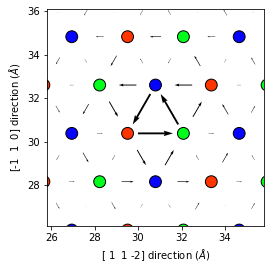

In [230]:
fig, ax = plt.subplots()
plot_vitek(W_screw_dislo, W_screw_bulk, alat=alat, xyscale=5, plot_axes=ax)
ax.set_aspect("equal")
ax.set_xlabel(f"{W_screw.axes[0]} direction ($\AA$)")
ax.set_ylabel(f"{W_screw.axes[1]} direction ($\AA$)");

We can use the ASE minimisation tools to minimise the structure using the chosen interatomic potential:

In [231]:
W_screw_dislo.calc = eam_calc
opt = PreconLBFGS(W_screw_dislo)
opt.run(fmax=0.01)


PreconLBFGS:   0  19:17:49    -1936.097946       2.5284
PreconLBFGS:   1  19:17:52    -1936.291357       0.3596
PreconLBFGS:   2  19:17:53    -1936.346476       0.2286
PreconLBFGS:   3  19:17:53    -1936.361691       0.6206
PreconLBFGS:   4  19:17:54    -1936.374519       0.1534
PreconLBFGS:   5  19:17:55    -1936.377157       0.0604
PreconLBFGS:   6  19:17:55    -1936.378302       0.0847
PreconLBFGS:   7  19:17:57    -1936.378545       0.0449
PreconLBFGS:   8  19:17:58    -1936.378652       0.0124
PreconLBFGS:   9  19:17:59    -1936.378665       0.0059


True

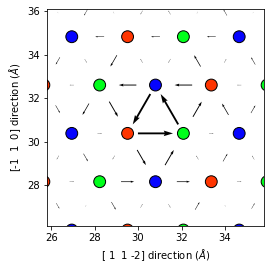

In [232]:
fig, ax = plt.subplots()
plot_vitek(W_screw_dislo, W_screw_bulk, alat=alat, xyscale=5, plot_axes=ax)
ax.set_aspect("equal")
ax.set_xlabel(f"{W_screw.axes[0]} direction ($\AA$)")
ax.set_ylabel(f"{W_screw.axes[1]} direction ($\AA$)");

Differential displacement map of the relaxed structure shows almost the same picture as before with symmetric 'easy' dislocation core. This means that for the selected interatomic potential this structure is indeed the most stable and that the initial guess of the displacement was reasonably good. 

### 1/2<111>{110} edge dislocation

As we said before, for edge dislocations burgers vecort $\vec b$ is perpendicular to the dislocation $\vec l$. So here, we have the same glide plane of (110) which fixes the cell Y direction to <110>. X direction now will be along burgers vector <111> and Z dislocation line direction <112>.

In [233]:
from matscipy.dislocation import BCCEdge111Dislocation

W_edge = BCCEdge111Dislocation(alat, C11, C12, C44, symbol="W")

print("Cell orientation:")
print(W_edge.axes)

print("Burgers vector:")
print(W_edge.burgers)


Cell orientation:
[[ 1  1  1]
 [ 1 -1  0]
 [ 1  1 -2]]
Burgers vector:
[1.57169453 1.57169453 1.57169453]


In [238]:
W_edge_bulk, W_edge_dislo = W_edge.build_cylinder(radius=15)

print("\nCell vectors:")
print(W_edge_dislo.cell.array)

print("\nBurgers vector lenth:")
print(np.linalg.norm(W_edge.burgers))

interactive_view(W_edge_dislo, scale=0.25, d_name="1/2<111> edge")

disloc SCF 0 |d1-d2|_inf = 0.17503717189385382
disloc SCF 1 |d1-d2|_inf = 0.030669651063355258
disloc SCF 2 |d1-d2|_inf = 0.004376489640269432
disloc SCF 3 |d1-d2|_inf = 0.0008807112000284167
disloc SCF 4 |d1-d2|_inf = 0.00015452837692353505
disloc SCF 5 |d1-d2|_inf = 2.6112647029508107e-05
disloc SCF 6 |d1-d2|_inf = 5.7487804006051135e-06
disloc SCF 7 |d1-d2|_inf = 7.771108773702018e-07

Cell vectors:
[[54.44509545  0.          0.        ]
 [ 0.         53.34508114  0.        ]
 [ 0.          0.          7.69969924]]

Burgers vector lenth:
2.722254772666657


NGLWidget()

It can be seen that the case of edge dislocation the requires more iterations to achieve converged displacement field.

In [235]:
W_edge_dislo.calc = eam_calc
opt = PreconLBFGS(W_edge_dislo)
opt.run(fmax=0.01)

PreconLBFGS:   0  19:18:04    -3017.104472       5.8264
PreconLBFGS:   1  19:18:09    -3017.709557       4.8423
PreconLBFGS:   2  19:18:10    -3018.145952       3.6773
PreconLBFGS:   3  19:18:11    -3018.510026       2.2950
PreconLBFGS:   4  19:18:12    -3018.881181       1.4546
PreconLBFGS:   5  19:18:14    -3019.132006       0.7013
PreconLBFGS:   6  19:18:15    -3019.257226       0.4936
PreconLBFGS:   7  19:18:16    -3019.309721       0.8501
PreconLBFGS:   8  19:18:18    -3019.331783       0.4275
PreconLBFGS:   9  19:18:21    -3019.340055       0.2540
PreconLBFGS:  10  19:18:23    -3019.343848       0.2224
PreconLBFGS:  11  19:18:24    -3019.345682       0.3022
PreconLBFGS:  12  19:18:26    -3019.347748       0.1698
PreconLBFGS:  13  19:18:27    -3019.348742       0.0915
PreconLBFGS:  14  19:18:30    -3019.349178       0.0348
PreconLBFGS:  15  19:18:31    -3019.349290       0.0489
PreconLBFGS:  16  19:18:32    -3019.349394       0.0276
PreconLBFGS:  17  19:18:34    -3019.349421      

True

In [239]:
interactive_view(W_edge_dislo, scale=0.25)

NGLWidget()

It can be seen that relaxed core structure differs significantly from the initial guess.

### 1/2<111>{110} mixed dislocation

For mixed dislocation the cell vector are the same as for the screw dislocation. However the displacement vector is applied along <111> direction that is not parallel to the Z direction: [$1\bar 11$] and [$1\bar 1 \bar1$] with an angle of 70.5 degrees between the vectors. This leads to both edge and screw component in the displacement and thus the name _mixed_ dislocation.

In [240]:
from matscipy.dislocation import BCCMixed111Dislocation

W_mixed = BCCMixed111Dislocation(alat, C11, C12, C44, symbol="W")

print("Cell orientation:")
print(W_mixed.axes)

print("Burgers vector:")
print(W_mixed.burgers)


Cell orientation:
[[ 1 -1 -2]
 [ 1  1  0]
 [ 1 -1  1]]
Burgers vector:
[ 1.57169453 -1.57169453 -1.57169453]


In [241]:
W_mixed_bulk, W_mixed_dislo = W_mixed.build_cylinder(radius=17)

print("\nCell vectors:")
print(W_mixed_dislo.cell.array)

print("\nBurgers vector lenth:")
print(np.linalg.norm(W_mixed.burgers))

interactive_view(W_mixed_dislo, scale=0.5, d_name="1/2<111> mixed")

disloc SCF 0 |d1-d2|_inf = 0.10539187767041772
disloc SCF 1 |d1-d2|_inf = 0.018105716735450528
disloc SCF 2 |d1-d2|_inf = 0.002853744720166418
disloc SCF 3 |d1-d2|_inf = 0.00044617599789692486
disloc SCF 4 |d1-d2|_inf = 6.968641396387643e-05
disloc SCF 5 |d1-d2|_inf = 1.0882499856867955e-05
disloc SCF 6 |d1-d2|_inf = 1.6994203833053945e-06
disloc SCF 7 |d1-d2|_inf = 2.653822296916353e-07

Cell vectors:
[[61.59759392  0.          0.        ]
 [ 0.         62.235928    0.        ]
 [ 0.          0.          2.72225477]]

Burgers vector lenth:
2.722254772666657


NGLWidget()

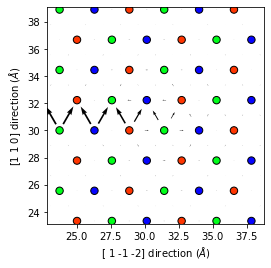

In [17]:
fig, ax = plt.subplots()
plot_vitek(W_mixed_dislo, W_mixed_bulk, alat=alat, xyscale=8, plot_axes=ax)
ax.set_aspect("equal")
ax.set_xlabel(f"{W_mixed.axes[0]} direction ($\AA$)")
ax.set_ylabel(f"{W_mixed.axes[1]} direction ($\AA$)");

It can be seen that the screw displacement component is not local as compared to the case of screw dislocation. This is because in this visualisation edge component of the displacement is not taken into account. It is the full displacement as screw plus edge component that makes a periodic vector leading to perfect structure and thus no displacement far from the dislocation core.

In [18]:
W_mixed_dislo.calc = eam_calc
opt = PreconLBFGS(W_mixed_dislo)
opt.run(fmax=0.01)

PreconLBFGS:   0  03:38:20    -1378.796248       6.1079
PreconLBFGS:   1  03:38:22    -1379.177213       5.5696
PreconLBFGS:   2  03:38:22    -1379.433663       3.8807
PreconLBFGS:   3  03:38:23    -1379.678510       2.8773
PreconLBFGS:   4  03:38:23    -1379.877582       1.7195
PreconLBFGS:   5  03:38:24    -1380.025502       1.0666
PreconLBFGS:   6  03:38:24    -1380.137929       0.4829
PreconLBFGS:   7  03:38:25    -1380.207642       0.7498
PreconLBFGS:   8  03:38:25    -1380.243153       0.6631
PreconLBFGS:   9  03:38:26    -1380.255664       0.5914
PreconLBFGS:  10  03:38:26    -1380.262623       0.6067
PreconLBFGS:  11  03:38:27    -1380.272531       0.2770
PreconLBFGS:  12  03:38:28    -1380.278262       0.2130
PreconLBFGS:  13  03:38:28    -1380.283088       0.2465
PreconLBFGS:  14  03:38:29    -1380.285881       0.1471
PreconLBFGS:  15  03:38:29    -1380.287260       0.1000
PreconLBFGS:  16  03:38:30    -1380.287853       0.0572
PreconLBFGS:  17  03:38:30    -1380.288051      

True

In [133]:
interactive_view(W_mixed_dislo, scale=0.5)

NameError: name 'W_mixed_dislo' is not defined

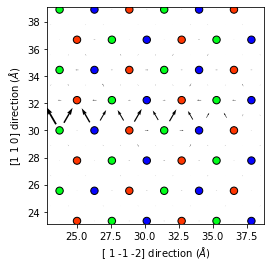

In [20]:
fig, ax = plt.subplots()
plot_vitek(W_mixed_dislo, W_mixed_bulk, alat=alat, xyscale=8, plot_axes=ax)
ax.set_aspect("equal")
ax.set_xlabel(f"{W_mixed.axes[0]} direction ($\AA$)")
ax.set_ylabel(f"{W_mixed.axes[1]} direction ($\AA$)");

Spreading of the dislocation core along the glide plane can be seen in the displacement map after relaxation.

### <100>{110} edge 'junction' dislocation

So called junction dislocations with burdgers vector along <100> can be formed in the reactions between more abundant dislocations with burgers vector <111> such as: 

$$
    \frac{1}{2}[1\bar{1}1] + \frac{1}{2}[11\bar{1}] = [100]
$$

They share the same glide plane ad 1/2<111> dislocations and can play important role in impurity segregation. 

In [242]:
from matscipy.dislocation import BCCEdge100110Dislocation

W_edge = BCCEdge100110Dislocation(alat, C11, C12, C44, symbol="W")

print("Cell orientation:")
print(W_edge.axes)

print("Burgers vector:")
print(W_edge.burgers)


Cell orientation:
[[ 1  0  0]
 [ 0  1  1]
 [ 0 -1  1]]
Burgers vector:
[3.14338905 0.         0.        ]


In [245]:
W_edge_bulk, W_edge_dislo = W_edge.build_cylinder(radius=15)
interactive_view(W_edge_dislo, scale=0.3, d_name="<100>{110} edge", d_color=[1, 0, 1])

disloc SCF 0 |d1-d2|_inf = 0.256011923011219
disloc SCF 1 |d1-d2|_inf = 0.060168757892788555
disloc SCF 2 |d1-d2|_inf = 0.008688239875985548
disloc SCF 3 |d1-d2|_inf = 0.002036859690120879
disloc SCF 4 |d1-d2|_inf = 0.00025500641555943615
disloc SCF 5 |d1-d2|_inf = 8.302194247189476e-05
disloc SCF 6 |d1-d2|_inf = 1.6579146270331857e-05
disloc SCF 7 |d1-d2|_inf = 1.7272275882884713e-06
disloc SCF 8 |d1-d2|_inf = 6.753932630942927e-07


NGLWidget()

In [244]:
W_edge_dislo.calc = eam_calc
opt = PreconLBFGS(W_edge_dislo)
opt.run(fmax=0.01)

PreconLBFGS:   0  19:21:55    -1730.274625       3.4262
PreconLBFGS:   1  19:21:57    -1730.777096       2.4833
PreconLBFGS:   2  19:21:58    -1731.178776       2.1508
PreconLBFGS:   3  19:21:59    -1731.476061       1.8160
PreconLBFGS:   4  19:21:59    -1731.690476       1.3641
PreconLBFGS:   5  19:22:00    -1731.853201       0.7966
PreconLBFGS:   6  19:22:00    -1731.973539       0.6496
PreconLBFGS:   7  19:22:01    -1732.026731       0.5298
PreconLBFGS:   8  19:22:02    -1732.042310       0.2325
PreconLBFGS:   9  19:22:03    -1732.049321       0.1783
PreconLBFGS:  10  19:22:04    -1732.051231       0.1082
PreconLBFGS:  11  19:22:05    -1732.052176       0.0623
PreconLBFGS:  12  19:22:07    -1732.052421       0.0465
PreconLBFGS:  13  19:22:08    -1732.052498       0.0273
PreconLBFGS:  14  19:22:10    -1732.052533       0.0196
PreconLBFGS:  15  19:22:11    -1732.052548       0.0112
PreconLBFGS:  16  19:22:12    -1732.052558       0.0087


True

In [ ]:
interactive_view(W_edge_dislo, scale=0.3)

### <100>{001} edge dislocation

This is the same junction dislocation but lying in a different glide plane.

In [247]:
from matscipy.dislocation import BCCEdge100Dislocation

W_edge = BCCEdge100Dislocation(alat, C11, C12, C44, symbol="W")

print("Cell orientation:")
print(W_edge.axes)

print("Burgers vector:")
print(W_edge.burgers)


Cell orientation:
[[ 1  0  0]
 [ 0  0 -1]
 [ 0  1  0]]
Burgers vector:
[3.14338905 0.         0.        ]


In [248]:
W_edge_bulk, W_edge_dislo = W_edge.build_cylinder(radius=15)
interactive_view(W_edge_dislo, scale=0.4, d_name="<100>{001} edge", d_color=[1, 0, 1])

disloc SCF 0 |d1-d2|_inf = 0.29723896079013645
disloc SCF 1 |d1-d2|_inf = 0.03893895819759963
disloc SCF 2 |d1-d2|_inf = 0.011189961805871285
disloc SCF 3 |d1-d2|_inf = 0.0014929016917481636
disloc SCF 4 |d1-d2|_inf = 0.00046542738716470744
disloc SCF 5 |d1-d2|_inf = 8.162136711144935e-05
disloc SCF 6 |d1-d2|_inf = 1.3593036749526277e-05
disloc SCF 7 |d1-d2|_inf = 4.3709609487407874e-06
disloc SCF 8 |d1-d2|_inf = 5.007713447247042e-07


NGLWidget()

In [157]:
W_edge_dislo.write("W_edge100.xyz")

In [ ]:
W_edge_dislo.calc = eam_calc
opt = PreconLBFGS(W_edge_dislo)
opt.run(fmax=0.01)

In [ ]:
interactive_view(W_edge_dislo, scale=0.4)

## Face Centered Cubic

Work in progress.

In [4]:
eam_calc = EAM("../../tests/FeCuNi.eam.alloy")

# the function accepts any ASE type of calculator
alat, C11, C12, C44 = get_elastic_constants(calculator=eam_calc, symbol="Ni")

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 14:23:49      -17.801046*       0.0001
Fitting C_11
Strain array([-0.02, -0.01,  0.  ,  0.01,  0.02])
Stress array([-5.12800014e+00, -2.50333320e+00, -1.41366167e-04,  2.37961959e+00,
        4.63379565e+00]) GPa
Cij (gradient) / GPa    :     244.0654437182867
Error in Cij / GPa      :     4.217968506243491
Correlation coefficient :     0.9995522932872427
Setting C11 (1) to 1.523337 +/- 0.026326


Fitting C_21
Strain array([-0.02, -0.01,  0.  ,  0.01,  0.02])
Stress array([-3.37539886e+00, -1.58459192e+00, -1.41366167e-04,  1.38619385e+00,
        2.58171226e+00]) GPa
Cij (gradient) / GPa    :     148.85008009740656
Error in Cij / GPa      :     6.776719382842348
Correlation coefficient :     0.9969053432709588
Setting C21 (7) to 0.929049 +/- 0.042297


Fitting C_31
Strain array([-0.02, -0.01,  0.  ,  0.01,  0.02])
Stress array([-3.37539886e+00, -1.58459192e+00, -1.41366167e-04,

In [5]:
print(f"{alat:.3f} (Angstrom), {C11:.2f}, {C12:.2f}, {C44:.2f} (GPa)")

3.520 (Angstrom), 244.07, 148.85, 125.62 (GPa)


In [6]:
from matscipy.dislocation import FCCScrew110Dislocation

Ni_screw = FCCScrew110Dislocation(alat, C11, C12, C44, symbol="Ni")

print("Cell orientation:")
print(Ni_screw.axes)

print("Burgers vector:")
print(Ni_screw.burgers)


Cell orientation:
[[ 1  1 -2]
 [ 1  1  1]
 [ 1 -1  0]]
Burgers vector:
[ 1.76 -1.76  0.  ]


In [55]:
Ni_screw_bulk, Ni_screw_dislo = Ni_screw.build_cylinder(radius=20)


print("\nCell vectors:")
print(Ni_screw_dislo.cell.array)

print("\nBurgers vector lenth:")
print(np.linalg.norm(Ni_screw.burgers))

interactive_view(Ni_screw_dislo, d_name="1/2<110> screw dislocation line", d_color=[0, 0, 1])

disloc SCF 0 |d1-d2|_inf = 0.021791458261984697
disloc SCF 1 |d1-d2|_inf = 0.0002936041882874109
disloc SCF 2 |d1-d2|_inf = 4.8928735380371347e-05
disloc SCF 3 |d1-d2|_inf = 1.2696678054050815e-06
disloc SCF 4 |d1-d2|_inf = 1.0764587210498888e-07
disloc SCF 0 |d1-d2|_inf = 0.020321133865591423
disloc SCF 1 |d1-d2|_inf = 0.0006134137472214689
disloc SCF 2 |d1-d2|_inf = 5.9406489367308524e-05
disloc SCF 3 |d1-d2|_inf = 2.948341477265748e-06
disloc SCF 4 |d1-d2|_inf = 8.340714410803862e-08

Cell vectors:
[[60.35542726  0.          0.        ]
 [ 0.         60.96818843  0.        ]
 [ 0.          0.          2.48901587]]

Burgers vector lenth:
2.4890158697766473


NGLWidget()

In [56]:
Ni_screw_bulk, Ni_screw_dislo = Ni_screw.build_cylinder(radius=20, partial_distance=5)
interactive_view(Ni_screw_dislo, partial_distance=5 * Ni_screw.glide_distance, d_name="1/6<112> Shockley partial screw")

disloc SCF 0 |d1-d2|_inf = 0.02179145826198453
disloc SCF 1 |d1-d2|_inf = 0.0002936041882874109
disloc SCF 2 |d1-d2|_inf = 4.892873538059339e-05
disloc SCF 3 |d1-d2|_inf = 1.2696678051752307e-06
disloc SCF 4 |d1-d2|_inf = 1.0764587193845543e-07
disloc SCF 0 |d1-d2|_inf = 0.020321133865591506
disloc SCF 1 |d1-d2|_inf = 0.0006134137472214689
disloc SCF 2 |d1-d2|_inf = 5.9406489367308524e-05
disloc SCF 3 |d1-d2|_inf = 2.948341477515548e-06
disloc SCF 4 |d1-d2|_inf = 8.340714444804442e-08


NGLWidget()

In [59]:
import nglview as nv
view = interactive_view(Ni_screw_dislo, partial_distance=5 * Ni_screw.glide_distance, d_name="1/6<112> Shockley partial screw")
view._remote_call("setSize", target="Widget", args=["600px", "600px"])
nv.write_html("Ni_screw.html", [view])    

In [254]:
from matscipy.dislocation import FCCEdge110Dislocation

Ni_edge = FCCEdge110Dislocation(alat, C11, C12, C44, symbol="Ni")

print("Cell orientation:")
print(Ni_edge.axes)

print("Burgers vector:")
print(Ni_edge.burgers)


Cell orientation:
[[ 1 -1  0]
 [ 1  1  1]
 [-1 -1  2]]
Burgers vector:
[ 1.76 -1.76  0.  ]


In [259]:
Ni_edge_bulk, Ni_edge_dislo = Ni_edge.build_cylinder(radius=20)

print("\nCell vectors:")
print(Ni_edge_dislo.cell.array)

print("\nBurgers vector lenth:")
print(np.linalg.norm(Ni_edge.burgers))

interactive_view(Ni_edge_dislo, d_name="1/2<110> edge", d_color=[0, 0, 1])

disloc SCF 0 |d1-d2|_inf = 0.04310715442453525
disloc SCF 1 |d1-d2|_inf = 0.0031359890399249857
disloc SCF 2 |d1-d2|_inf = 0.00018078113282300745
disloc SCF 3 |d1-d2|_inf = 1.4501349156037513e-05
disloc SCF 4 |d1-d2|_inf = 9.978781161934513e-07
disloc SCF 0 |d1-d2|_inf = 0.03462421627571943
disloc SCF 1 |d1-d2|_inf = 0.0022123322463467043
disloc SCF 2 |d1-d2|_inf = 0.00021564683900149317
disloc SCF 3 |d1-d2|_inf = 1.1838612354972411e-05
disloc SCF 4 |d1-d2|_inf = 6.324895580611667e-07

Cell vectors:
[[64.71441261  0.          0.        ]
 [ 0.         60.96818843  0.        ]
 [ 0.          0.          4.31110195]]

Burgers vector lenth:
2.4890158697766473


NGLWidget()

In [260]:
Ni_edge_bulk, Ni_edge_dislo = Ni_edge.build_cylinder(radius=20, partial_distance=10)
interactive_view(Ni_edge_dislo, partial_distance=10 * Ni_edge.glide_distance, d_name="1/2<110> Shockley partial edge")

disloc SCF 0 |d1-d2|_inf = 0.04310715442453525
disloc SCF 1 |d1-d2|_inf = 0.0031359890399249857
disloc SCF 2 |d1-d2|_inf = 0.00018078113282300745
disloc SCF 3 |d1-d2|_inf = 1.4501349155759957e-05
disloc SCF 4 |d1-d2|_inf = 9.978781162003902e-07
disloc SCF 0 |d1-d2|_inf = 0.03462421627571943
disloc SCF 1 |d1-d2|_inf = 0.002212332246347065
disloc SCF 2 |d1-d2|_inf = 0.00021564683900149317
disloc SCF 3 |d1-d2|_inf = 1.1838612354972411e-05
disloc SCF 4 |d1-d2|_inf = 6.324895580611667e-07


NGLWidget()

## Diamond 

Work in progress.

In [261]:
from matscipy.calculators.manybody.explicit_forms.stillinger_weber import StillingerWeber, Holland_Marder_PRL_80_746_Si
from matscipy.calculators.manybody import Manybody
calc = Manybody(**StillingerWeber(Holland_Marder_PRL_80_746_Si))

# the function accepts any ASE type of calculator
alat, C11, C12, C44 = get_elastic_constants(calculator=calc, symbol="Si")

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 19:25:22      -34.692786*       0.0922
FIRE:    1 19:25:22      -34.692742*       0.1881
FIRE:    2 19:25:22      -34.692797*       0.0452
FIRE:    3 19:25:22      -34.692771*       0.1323
FIRE:    4 19:25:22      -34.692781*       0.1071
FIRE:    5 19:25:22      -34.692794*       0.0616
FIRE:    6 19:25:22      -34.692800*       0.0043
FIRE:    7 19:25:22      -34.692795*       0.0537
FIRE:    8 19:25:22      -34.692796*       0.0511
FIRE:    9 19:25:22      -34.692796*       0.0461
FIRE:   10 19:25:22      -34.692798*       0.0390
FIRE:   11 19:25:22      -34.692799*       0.0299
FIRE:   12 19:25:22      -34.692799*       0.0195
FIRE:   13 19:25:22      -34.692800*       0.0081
FIRE:   14 19:25:22      -34.692800*       0.0036
FIRE:   15 19:25:22      -34.692800*       0.0036
FIRE:   16 19:25:22      -34.692800*       0.0035
FIRE:   17 19:25:22      -34.692800*       0.0034
FI

In [262]:
print(f"{alat:.3f} (Angstrom), {C11:.2f}, {C12:.2f}, {C44:.2f} (GPa)")

5.431 (Angstrom), 201.46, 51.64, 118.18 (GPa)


In [263]:
from matscipy.dislocation import DiamondGlideScrew

Si_screw = DiamondGlideScrew(alat, C11, C12, C44, symbol="Si")

print("Cell orientation:")
print(Si_screw.axes)

print("Burgers vector:")
print(Si_screw.burgers)


Cell orientation:
[[ 1  1 -2]
 [ 1  1  1]
 [ 1 -1  0]]
Burgers vector:
[ 2.71547466 -2.71547466  0.        ]


In [264]:
Si_screw_bulk, Si_screw_dislo = Si_screw.build_cylinder(radius=20)

print("\nCell vectors:")
print(Si_screw_dislo.cell.array)

print("\nBurgers vector lenth:")
print(np.linalg.norm(Si_screw.burgers))
Si_screw_dislo.wrap()
interactive_view(Si_screw_dislo, diamond_structure=True, scale=0.3, add_bonds=True, d_name="1/2<110> screw", d_color=[0, 0, 1])


Cell vectors:
[[66.51527324  0.          0.        ]
 [ 0.         75.25344122  0.        ]
 [ 0.          0.          3.84026109]]

Burgers vector lenth:
3.840261091032201


NGLWidget()

In [265]:
Si_screw_bulk, Si_screw_dislo = Si_screw.build_cylinder(radius=20, partial_distance=5)
Si_screw_dislo.wrap()
interactive_view(Si_screw_dislo, diamond_structure=True, scale=0.3, add_bonds=True, partial_distance=5 * Si_screw.glide_distance, 
                 d_name="1/6<112> 30 degree partial screw") 

NGLWidget()

In [266]:
from matscipy.dislocation import DiamondGlide60Degree

Si_screw = DiamondGlide60Degree(alat, C11, C12, C44, symbol="Si")

print("Cell orientation:")
print(Si_screw.axes)

print("Burgers vector:")
print(Si_screw.burgers)


Cell orientation:
[[ 1  1 -2]
 [ 1  1  1]
 [ 1 -1  0]]
Burgers vector:
[ 2.71547466  0.         -2.71547466]


In [267]:
Si_screw_bulk, Si_screw_dislo = Si_screw.build_cylinder(radius=20)

print("\nCell vectors:")
print(Si_screw_dislo.cell.array)

print("\nBurgers vector lenth:")
print(np.linalg.norm(Si_screw.burgers))
Si_screw_dislo.wrap()
interactive_view(Si_screw_dislo, diamond_structure=True, scale=0.3, add_bonds=True,
                 d_name="1/2<110> 60 degree screw", d_color=[0, 0, 1])


Cell vectors:
[[66.51527324  0.          0.        ]
 [ 0.         75.25344122  0.        ]
 [ 0.          0.          3.84026109]]

Burgers vector lenth:
3.840261091032201


NGLWidget()

In [272]:
Si_screw_bulk, Si_screw_dislo = Si_screw.build_cylinder(radius=20, partial_distance=5)
Si_screw_dislo.wrap()
interactive_view(Si_screw_dislo, diamond_structure=True, scale=0.3, add_bonds=True,
                 partial_distance=5 * Si_screw.glide_distance, 
                 d_name=["1/6<112> 90 degree partial screw", "1/6<112> 30 degree partial screw"])

NGLWidget()